In [1]:
#loading libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [3]:
# #loading data

# download.file("https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn", "tennis_data.csv")
 tennis_data <- read_csv("tennis_data.csv", show_col_types = FALSE)
# #tennis_data

New names:
• `` -> `...1`


In [4]:
#prepping data
set.seed(2132)

winner_data <- tennis_data |> select(winner_rank_points, winner_ht, w_df, w_bpSaved, w_bpFaced) |> 
    filter(w_bpSaved != 0) |> filter(w_bpFaced != 0) |> mutate(w_bpRatio = w_bpSaved/w_bpFaced) |> na.omit()
loser_data <- tennis_data |> select(loser_rank_points, loser_ht, l_df, l_bpSaved, l_bpFaced) |> 
    filter(l_bpSaved != 0) |> filter(l_bpFaced != 0) |> mutate(l_bpRatio = l_bpSaved/l_bpFaced) |> na.omit()

winner_split <- initial_split(winner_data, prop = .75, strata = winner_rank_points)  
winner_train <- training(winner_split)
winner_test <- testing(winner_split)
#winner_train

loser_split <- initial_split(loser_data, prop = .75, strata = loser_rank_points)  
loser_train <- training(loser_split)
loser_test <- testing(loser_split)
#loser_train

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
73,rmse,standard,2062.388,5,85.69833,Preprocessor1_Model24


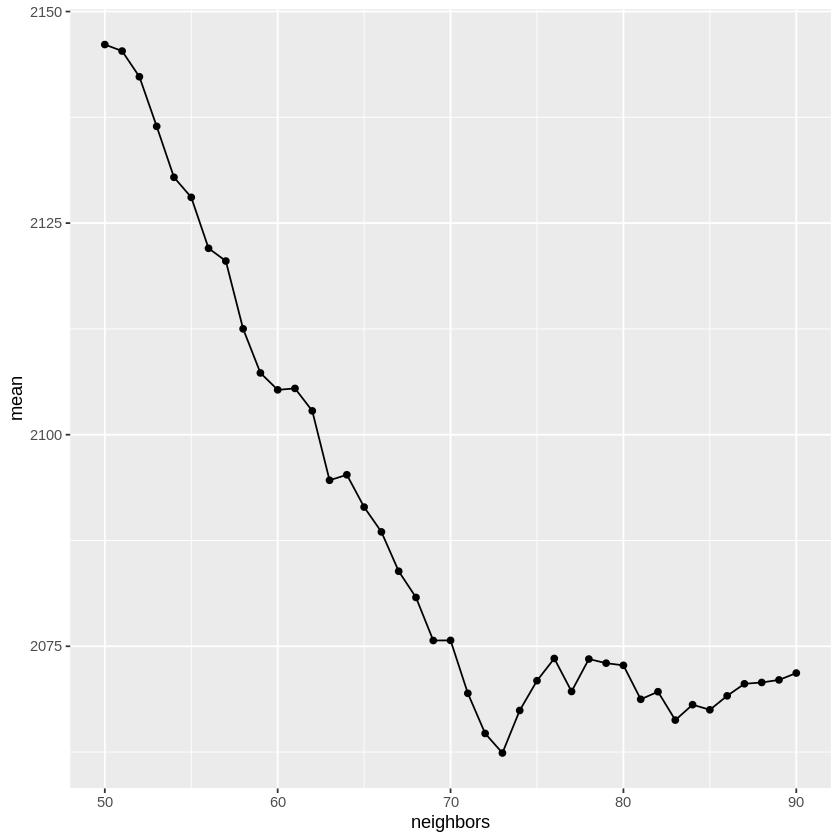

In [9]:
# testing/tuning winner regression

# height only: best k = 540 -  rmse = 2078.592
# height and df: best k = 107 - rmse = 2095.637
# height, df, bp: best k =  - rmse = 
# df and bp: best k =  - rmse = 
# height and bp: best k = 73 - rmse = 2062.388

set.seed(5342)

win_recipe <- recipe(winner_rank_points ~ winner_ht + w_bpRatio, data = winner_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

win_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

win_workflow <- workflow() |>
    add_recipe(win_recipe) |>
    add_model(win_spec)

win_vfold <- vfold_cv(winner_train, v = 5, strata = winner_rank_points)
gridvals <- tibble(neighbors = seq(from = 50, to = 90, by = 1))

win_results <- win_workflow |>
    tune_grid(resamples = win_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

win_min <- win_results |>
    filter(mean == min(mean))
win_min

k_win_selec <- ggplot(win_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_win_selec

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
72,rmse,standard,1357.321,5,85.44175,Preprocessor1_Model23


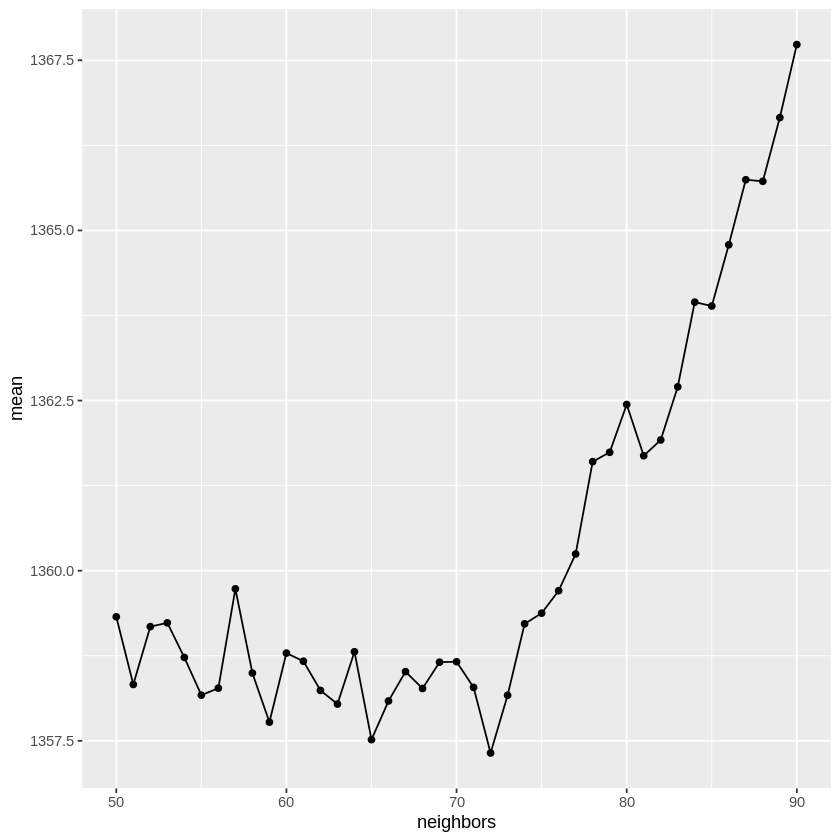

In [12]:
# testing/tuning loser regression

# height only: best k = 384 - rmse = 1323.389
# height and df: best k = 58  - rmse = 1294.647
# height, df, bp: best k =  - rmse = 
# df and bp: best k =  - rmse = 
# height and bp: best k = 72 - rmse = 1357.321

set.seed(4892)

lose_recipe <- recipe(loser_rank_points ~ loser_ht + l_bpRatio, data = loser_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

lose_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

lose_workflow <- workflow() |>
    add_recipe(lose_recipe) |>
    add_model(lose_spec)

lose_vfold <- vfold_cv(loser_train, v = 5, strata = loser_rank_points)
gridvals <- tibble(neighbors = seq(from = 50, to = 90, by = 1))

lose_results <- lose_workflow |>
    tune_grid(resamples = lose_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse")

lose_min <- lose_results |>
    filter(mean == min(mean))
lose_min

k_lose_selec <- ggplot(lose_results, aes(x = neighbors, y = mean)) + geom_point() + geom_line()
k_lose_selec

In [ ]:
# winner regression

win_recipe <- recipe(winner_rank_points ~ winner_ht, data = winner_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

win_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 540) |>
    set_engine("kknn") |>
    set_mode("regression")

win_workflow <- workflow() |>
    add_recipe(win_recipe) |>
    add_model(win_spec) |>
    fit(data = winner_train)
win_workflow

In [ ]:
# loser regression

lose_recipe <- recipe(loser_rank_points ~ loser_ht, data = loser_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

lose_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 384) |>
    set_engine("kknn") |>
    set_mode("regression")

lose_workflow <- workflow() |>
    add_recipe(lose_recipe) |>
    add_model(lose_spec) |>
    fit(data = loser_train)
lose_workflow